In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seawater
import xarray as xr
import scipy.signal as sp
import pandas as pd

%matplotlib inline

# Potential sub-surface channel
This notebook will contain the update as we step forward implementing the **Potential Sub-surface** acoustic variable.It is a boolean that indicates the potential existence of a sub-surface sound channel. 

>*A sub-surface sound channel can exist if there are two local minima in the sound speed profile above 1000 m.*

### Importing a sample profile

In [63]:
#profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-01-22T16_45_30.510267.csv", comment='/') 
profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-01-22T16_45_30.510267.csv", header=2) 

In [62]:
profile.columns

Index(['Latitude', ' Longitude', 'Depth (m)', 'Pressure', 'Salinity',
       'Temperature', 'Sound Speed'],
      dtype='object')

In [52]:
profile_depth_sspeed = profile[['Sound Speed', 'Depth (m)']] # extracting only the soundspeed and depth column
profile_depth_sspeed

,Sound Speed,Depth (m)
0,1448.4,0.5
1,1448.5,1.5
2,1448.5,2.6
3,1448.5,3.8
4,1448.5,5.1
5,1448.5,6.4
6,1448.6,7.9
7,1448.6,9.6
8,1448.6,11.4
9,1448.7,13.5


Text(0.5, 0, 'Speed of sound [m/s]')

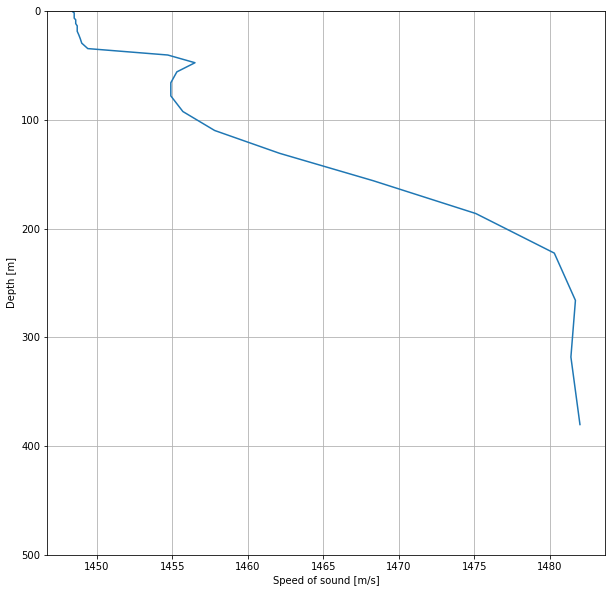

In [53]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(profile_depth_sspeed['Sound Speed'], profile_depth_sspeed['Depth (m)'])
ax.grid(True)
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')

Using the *argrelmin()* function from scipy to detect the localminima

In [78]:
profile_np = np.array(profile_depth_sspeed['Sound Speed'])
local_minima = sp.argrelmin(profile_np) # get the index array of local minima
local_minima
local_maxima = sp.argrelmax(profile_np) # get the index array of the local macima
local_maxima

(array([17, 27]),)

Plotting the returned minima.

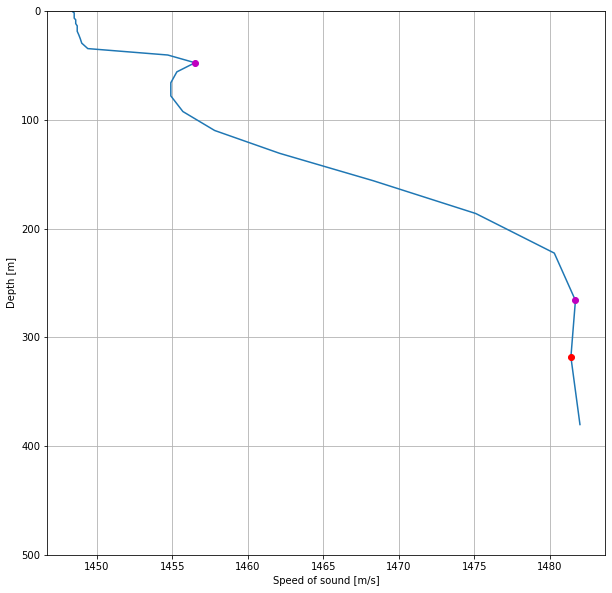

In [81]:

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(profile_depth_sspeed['Sound Speed'], profile_depth_sspeed['Depth (m)'])
ax.grid(True)
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')
ax.plot(profile_depth_sspeed['Sound Speed'][local_minima[0]],profile_depth_sspeed['Depth (m)'][local_minima[0]],'r.',markersize=12)
ax.plot(profile_depth_sspeed['Sound Speed'][local_maxima[0]],profile_depth_sspeed['Depth (m)'][local_maxima[0]],'m.',markersize=12)